**Multi-varable Kalman filter for object trajectory**

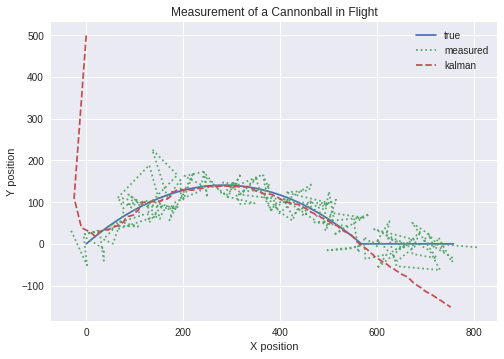

In [7]:
import pylab
import math
import random
import numpy

# Implements a linear Kalman filter.
class KalmanFilterLinear:
  def __init__(self,_A, _B, _H, _x, _P, _Q, _R):
    self.A = _A                      # State transition matrix.
    self.B = _B                      # Control matrix.
    self.H = _H                      # Observation matrix.
    self.current_state_estimate = _x # Initial state estimate.
    self.current_prob_estimate = _P  # Initial covariance estimate.
    self.Q = _Q                      # Estimated error in process.
    self.R = _R                      # Estimated error in measurements.
  def GetCurrentState(self):
    return self.current_state_estimate
  def Step(self,control_vector,measurement_vector):
    #---------------------------Prediction step-----------------------------
    predicted_state_estimate = self.A * self.current_state_estimate + self.B * control_vector
    predicted_prob_estimate = (self.A * self.current_prob_estimate) * numpy.transpose(self.A) + self.Q
    #--------------------------Observation step-----------------------------
    innovation = measurement_vector - self.H*predicted_state_estimate
    innovation_covariance = self.H*predicted_prob_estimate*numpy.transpose(self.H) + self.R
    #-----------------------------Update step-------------------------------
    kalman_gain = predicted_prob_estimate * numpy.transpose(self.H) * numpy.linalg.inv(innovation_covariance)
    self.current_state_estimate = predicted_state_estimate + kalman_gain * innovation
    # We need the size of the matrix so we can make an identity matrix.
    size = self.current_prob_estimate.shape[0]
    # eye(n) = nxn identity matrix.
    self.current_prob_estimate = (numpy.eye(size)-kalman_gain*self.H)*predicted_prob_estimate

# Simulates the classic physics problem of a cannon shooting a ball in a
# parabolic arc.  In addition to giving "true" values back, you can also ask
# for noisy values back to test Kalman filters.
class Cannon:
  #--------------------------------VARIABLES----------------------------------
  angle = 45 # The angle from the ground to point the cannon.
  muzzle_velocity = 75 # Muzzle velocity of the cannon.
  gravity = [0,-9.81] # A vector containing gravitational acceleration.
  # The initial velocity of the cannonball
  velocity = [muzzle_velocity*math.cos(angle*math.pi/180), muzzle_velocity*math.sin(angle*math.pi/180)]
  loc = [0,0] # The initial location of the cannonball.
  acceleration = [0,0] # The initial acceleration of the cannonball.
  #---------------------------------METHODS-----------------------------------
  def __init__(self,_timeslice,_noiselevel):
    self.timeslice = _timeslice
    self.noiselevel = _noiselevel
  def add(self,x,y):
    return x + y
  def mult(self,x,y):
    return x * y
  def GetX(self):
    return self.loc[0]
  def GetY(self):
    return self.loc[1]
  def GetXWithNoise(self):
    return random.gauss(self.GetX(),self.noiselevel)
  def GetYWithNoise(self):
    return random.gauss(self.GetY(),self.noiselevel)
  def GetXVelocity(self):
    return self.velocity[0]
  def GetYVelocity(self):
    return self.velocity[1]
  # Increment through the next timeslice of the simulation.
  def Step(self):
    # We're gonna use this vector to timeslice everything.
    timeslicevec = [self.timeslice,self.timeslice]
    # Break gravitational force into a smaller time slice.
    sliced_gravity = map(self.mult,self.gravity,timeslicevec)
    # The only force on the cannonball is gravity.
    sliced_acceleration = sliced_gravity
    # Apply the acceleration to velocity.
    self.velocity = map(self.add, self.velocity, sliced_acceleration)
    sliced_velocity = map(self.mult, self.velocity, timeslicevec )
    # Apply the velocity to location.
    self.loc = map(self.add, self.loc, sliced_velocity)
    # Cannonballs shouldn't go into the ground.
    if self.loc[1] < 0:
      self.loc[1] = 0

#=============================REAL PROGRAM START================================
# Let's go over the physics behind the cannon shot, just to make sure it's
# correct:
# sin(45)*100 = 70.710 and cos(45)*100 = 70.710
# vf = vo + at
# 0 = 70.710 + (-9.81)t
# t = 70.710/9.81 = 7.208 seconds for half
# 14.416 seconds for full journey
# distance = 70.710 m/s * 14.416 sec = 1019.36796 m

timeslice = 0.1 # How many seconds should elapse per iteration?
iterations = 144 # How many iterations should the simulation run for?
# (notice that the full journey takes 14.416 seconds, so 145 iterations will
# cover the whole thing when timeslice = 0.10)
noiselevel = 30  # How much noise should we add to the noisy measurements?


# These are arrays to store the data points we want to plot at the end.
x = []
y = []
nx = []
ny = []
kx = []
ky = []

# Let's make a cannon simulation.
c = Cannon(timeslice,noiselevel)

speedX = muzzle_velocity*math.cos(angle*math.pi/180)
speedY = muzzle_velocity*math.sin(angle*math.pi/180)

# This is the state transition vector, which represents part of the kinematics.
# 1, ts, 0,  0  =>  x(n+1) = x(n) + vx(n)
# 0,  1, 0,  0  => vx(n+1) =        vx(n)
# 0,  0, 1, ts  =>  y(n+1) =              y(n) + vy(n)
# 0,  0, 0,  1  => vy(n+1) =                     vy(n)
# Remember, acceleration gets added to these at the control vector.
state_transition = numpy.matrix([[1,timeslice,0,0],[0,1,0,0],[0,0,1,timeslice],[0,0,0,1]])

control_matrix = numpy.matrix([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,1]])
# The control vector, which adds acceleration to the kinematic equations.
# 0          =>  x(n+1) =  x(n+1)
# 0          => vx(n+1) = vx(n+1)
# -9.81*ts^2 =>  y(n+1) =  y(n+1) + 0.5*-9.81*ts^2
# -9.81*ts   => vy(n+1) = vy(n+1) + -9.81*ts
control_vector = numpy.matrix([[0],[0],[0.5*-9.81*timeslice*timeslice],[-9.81*timeslice]])

# After state transition and control, here are the equations:
#  x(n+1) = x(n) + vx(n)
# vx(n+1) = vx(n)
#  y(n+1) = y(n) + vy(n) - 0.5*9.81*ts^2
# vy(n+1) = vy(n) + -9.81*ts
# Which, if you recall, are the equations of motion for a parabola.  Perfect.

# Observation matrix is the identity matrix, since we can get direct
# measurements of all values in our example.
observation_matrix = numpy.eye(4)

# This is our guess of the initial state.  I intentionally set the Y value
# wrong to illustrate how fast the Kalman filter will pick up on that.
initial_state = numpy.matrix([[0],[speedX],[500],[speedY]])

initial_probability = numpy.eye(4)

process_covariance = numpy.zeros(4)
measurement_covariance = numpy.eye(4)*0.2

kf = KalmanFilterLinear(state_transition, control_matrix, observation_matrix, initial_state, initial_probability, process_covariance, measurement_covariance)

# Iterate through the simulation.
for i in range(iterations):
    x.append(c.GetX())
    y.append(c.GetY())
    newestX = c.GetXWithNoise()
    newestY = c.GetYWithNoise()
    nx.append(newestX)
    ny.append(newestY)
    # Iterate the cannon simulation to the next timeslice.
    c.Step()
    kx.append(kf.GetCurrentState()[0,0])
    ky.append(kf.GetCurrentState()[2,0])
    kf.Step(control_vector,numpy.matrix([[newestX],[c.GetXVelocity()],[newestY],[c.GetYVelocity()]]))

# Plot all the results we got.
pylab.plot(x,y,'-',nx,ny,':',kx,ky,'--')
pylab.xlabel('X position')
pylab.ylabel('Y position')
pylab.title('Measurement of a Cannonball in Flight')
pylab.legend(('true','measured','kalman'))
pylab.show()